In [15]:
from gimpformats.gimpXcfDocument import GimpDocument
import cv2
import numpy as np

# Concave hull
import os
import sys
import pandas as pd
from descartes import PolygonPatch
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))
import alphashape

In [16]:
def imageListFromXcf(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        extract and return a list of images along with a list of layer names, return it as two lists
    """

    """List data on groups followed by the direct children of a gimp xcf document
    """
    project = GimpDocument(fileName)

    layers = project.layers
    index = 0
    #print("## Group info...")
    #while index < len(layers):
    #    layerOrGroup = layers[index]
    #    if layerOrGroup.isGroup:
    #        index += 1
    #        while layers[index].itemPath is not None:
    #            #print("Group \"" + layerOrGroup.name + "\" contains Layer \"" + layers[index].name + "\"")
    #            layers.pop(index)
    #    else:
    #        index += 1

    #print("## Document direct children...")
    #images = []
    #for layerOrGroup in layers:
    #    print("\"" + layerOrGroup.name + "\" is a " + ("Group" if layerOrGroup.isGroup else "Layer"))
    #    images.append(layerOrGroup.image)
        #layerOrGroup.image.save(layerOrGroup.name+"amb.png")
    return zip(*[(l.name,l.image) for l in layers if not l.isGroup ][:-1])# CAREFUL!
    # Taking out the last one as it contains the full image!!!!!
   

    
def imageToPoints(image):
    
    # binarize image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray > 0] = 255  

    #compute connected components
    numLabels, labelImage,stats, centroids = cv2.connectedComponentsWithStats(gray)
    
    #print("returning "+str(centroids[1:]))
    #plt.imshow(image)
   
    return centroids[1:] #eliminate background centroid

def makeDict(names,points):
    return { names[i]: points[i] for i in range(len(names)) }
    

def readAnnotationFile(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        First extract a list of images, 
        Then extract from each image the landmark points
        return the name of each layer along with the list of points
    """

    
    names,images = imageListFromXcf(fileName)
    points = [imageToPoints(np.array(x)) for x in images]
    
    return names,images,points

In [17]:
# POINT METRICS
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import persim

def hausdorff(set1,set2):
    """ Given two sets of points, compute their hausdorff distance

    """    
    #print("Computing hausdorf distance of set "+str(set1)+" and "+str(set2))
    return directed_hausdorff(set1,set2)
        
"""
The following function can be made much more efficient with Kd-trees (but probably no need given our data sizes)
"""
def avEUC(set1,set2):
    """
    Average euclidean distance from a point in one set to the closest point in the other set
    """
    def closestDist(p, set2):
        """
            Smaller euclidean Distance from point to set
        """
        minDist = np.linalg.norm(p - set2[0])
        for q in set2[1:]:
            newDist = np.linalg.norm(p - q)
            if newDist < minDist:
                minDist = newDist
        return minDist
    # iterate over all the set
    sum = 0
    for p in set1:
        sum+=closestDist(p,set2)
    return sum/len(set1)
    
def bottleneck(set1,set2):
    """
        Bottleneck Distance between point sets
    """
    return persim.bottleneck(set1, set2, matching=True)[0]

    

In [18]:
# IMAGE METRICS
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import normalized_mutual_information as nim

def MSE(im1,im2):
    """
    Mean Squared Error image metric
    """
    return  mean_squared_error(img1, im2)

def SSIM(im1,im2):
    """
    Structural Similarity Index image metric
    """
    return ssim(im1, im2,data_range=max(im1.max(),im2.max()) - min(im1.min(),im2.min()))

def NMI(im1,im2):
    """
    Normalized mutual informacion image metric
    """
    return nmi(im1,im2)

In [93]:
# Function that returns a concave hull from a set of points
def concave_hull(points,alpha = 0.2):
    """
    Compute the concave hull of a set of points, at least 5 points are recommended
    3 are necessary
    """
    if len(points)<=2: raise Exception("Concave_hull Hull, cannot compute with less than 3 points")
    return alphashape.alphashape(points, alpha)

# Function that returns a convex hull from a set of points
def convex_hull(points):
    """
    Compute the convex hull of a set of points, at least 2 points are necessary
    """
    if len(points)<=2: raise Exception("Convex Hull, cannot compute with less than 3 points")
    return alphashape.alphashape(points, 0.)

def hull(points,alpha=0):
    if len(points)<5:return convex_hull(points)
    else: return concave_hull(points,alpha)

# Function that receives two polygons and computes two binary images with coordinates that contain them both
def polygonsToMasks(poly1,poly2):
    print(poly1.bounds)
    print(poly2.bounds)
    

In [85]:
def overlap(im1,im2):
    """
    Given two binary images, return the number of the pixels in the first image 
    that are also black in the second 
    """
    return np.sum(im1 == 0 and im2 ==0)    

('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
4
4
8
4
3
2
2


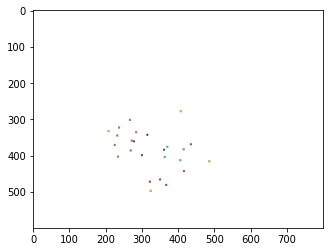

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

names,images,points = readAnnotationFile("data/3.xcf")

print(names)
for x in points:
    print(len(x))

plt.imshow(images[0])
plt.imshow(images[1])
plt.imshow(images[2])
plt.imshow(images[3])
plt.imshow(images[4])
plt.imshow(images[5])

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


names,_,points1 = readAnnotationFile("data/1.xcf")
dict1 = makeDict(names,points1)

names2,_,points2 = readAnnotationFile("data/Clandmarks.xcf")
dict2 = makeDict(names2,points2)

names3,_,points3 = readAnnotationFile("data/3.xcf")
dict3 = makeDict(names3,points3)

names4,_,points4 = readAnnotationFile("data/4.xcf")
dict4 = makeDict(names4,points4)

print("not all the annotations contain the same layers")
print(names)
print(names2)
print(names3)
print(names4)

print("lists of layers with their assigned points")
print(dict1)
print(dict2)
print(dict3)
print(dict4)

not all the annotations contain the same layers
('Córtex', 'calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
('linia mitja', 'astes anteriors', 'silvio', 'cerebel #1', 'c3', 'cerebel', 'talems', 'calota', 'Córtex')
('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
lists of layers with their assigned points
{'Córtex': array([[273., 466.],
       [303., 476.]]), 'calota': array([[342., 186.],
       [569., 324.],
       [192., 357.],
       [368., 498.]]), 'talems': array([[428., 296.],
       [462., 331.],
       [356., 341.],
       [432., 371.]]), 'cerebel': array([[507., 258.],
       [543., 295.],
       [468., 299.],
       [533., 327.],
       [470., 333.],
       [544., 358.],
       [475., 363.],
       [520., 397.]]), 'cavum': array([[297., 325.],
       [345., 327.],
       [302., 358.],
       [348., 358.]]), 'silvio': array

In [26]:
# now, take the points that we have computed and use them to compute some distances
aDict = dict1
anotherDict = dict2

for lay in aDict.keys():
    if lay in dict2:
        # retrieve points 
        set1 = aDict[lay]
        set2 = anotherDict[lay]
        distances = [bottleneck, hausdorff,avEUC]
        for distance in distances:
            dist = distance(set1,set2)
            print("Distance "+str(distance)+" computed for layer "+str(lay)+" : "+str(dist))

Distance <function bottleneck at 0x7fd4a4e3c8c8> computed for layer Córtex : 96.5
Distance <function hausdorff at 0x7fd489df5840> computed for layer Córtex : (186.02419197512995, 1, 1)
Distance <function avEUC at 0x7fd4a4e3c950> computed for layer Córtex : 173.36288938750596
Distance <function bottleneck at 0x7fd4a4e3c8c8> computed for layer calota : 96.0
Distance <function hausdorff at 0x7fd489df5840> computed for layer calota : (232.72515979154468, 1, 1)
Distance <function avEUC at 0x7fd4a4e3c950> computed for layer calota : 134.01402922048612
Distance <function bottleneck at 0x7fd4a4e3c8c8> computed for layer talems : -7.5
Distance <function hausdorff at 0x7fd489df5840> computed for layer talems : (205.06584308460538, 3, 3)
Distance <function avEUC at 0x7fd4a4e3c950> computed for layer talems : 175.06179810230913
Distance <function bottleneck at 0x7fd4a4e3c8c8> computed for layer cerebel : -50.5
Distance <function hausdorff at 0x7fd489df5840> computed for layer cerebel : (217.414350

calota
POLYGON ((490 156, 208 317, 477 516, 656 358, 490 156))


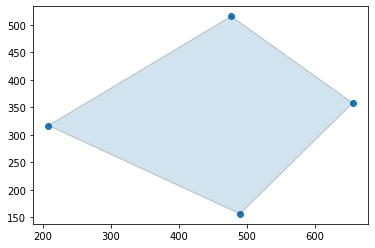

talems
POLYGON ((390 289, 334 331, 381 390, 466 343, 390 289))


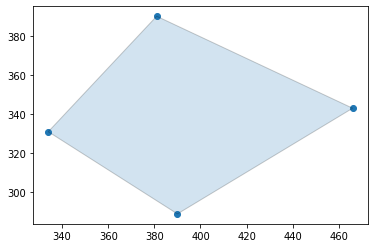

cerebel
POLYGON ((277 407, 324 364, 330 330, 333 294, 296 245, 254 280, 255 319, 250 355, 277 407))


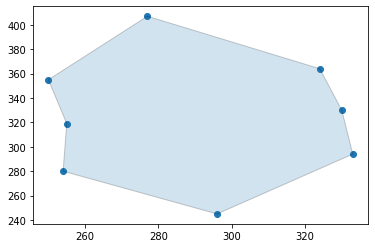

cavum
POLYGON ((477 326, 475 362, 524 363, 524 328, 477 326))


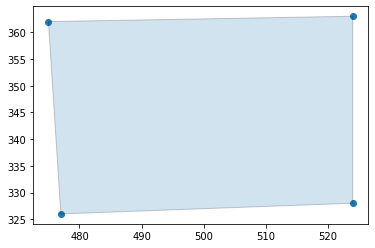

silvio
POLYGON ((464 465, 431 475, 498 467, 464 465))


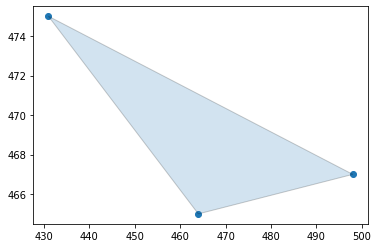

astes anteriors
Layer astes anteriors has too few points 0
linia mitja
Layer linia mitja has too few points 2


In [92]:
# Compute the concave and convex hulls of a data set
aDict = dict4
# Retrieve all layers
for lay in aDict.keys():
    #for every layer, get its points
    aPointSet = aDict[lay]
    print(lay)
    #if we don't have at least 3 points we cannot compute anything
    if len(aPointSet) > 2 :
        # compute convex or concave hull depending on how many points we have
        if len(aPointSet) > 5:
            hull = concave_hull(aPointSet,0.02)
        else:
            hull = concave_hull(aPointSet,0)
        fig, ax = plt.subplots()
        ax.scatter(*zip(*aPointSet))
        print(hull)
        ax.add_patch(PolygonPatch(hull,alpha = 0.2))
        plt.savefig(lay+".png")
        plt.show()
    else:
        print("Layer "+lay+" has too few points "+str(len(aPointSet)))

In [95]:
# Given two images, compute the hulls of all layers and compute their dice
# now, take the points that we have computed and use them to compute some distances
aDict = dict1
anotherDict = dict2

for lay in aDict.keys():
    if lay in dict2:
        # retrieve points 
        set1 = aDict[lay]
        set2 = anotherDict[lay]
        if len(set1) > 2 and len(set2)>2:
            poly1 = hull(set1)
            poly2 = hull(set2)
            
            print(polygonsToMasks(poly1,poly2))
    

(192.0, 186.0, 569.0, 498.0)
(49.0, 62.0, 400.0, 350.0)
None
(356.0, 296.0, 462.0, 371.0)
(226.0, 165.0, 306.0, 225.0)
None
(468.0, 258.0, 544.0, 397.0)
(313.0, 117.0, 378.0, 252.0)
None
(321.0, 452.0, 390.0, 474.0)
(213.0, 305.0, 263.0, 318.0)
None
